In [1]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

ide_plot() #plot for github dark theme

In [2]:
# Load main dataset
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [5]:
dataset.shape

(102, 1158)

In [6]:
reduce_model = ReduceModel(model="AE", layers=(dataset.shape[1], 500, 200, 10))
reduce_model.train(epochs=60, lr=1e-3)

100%|██████████| 60/60 [00:47<00:00,  1.26it/s]

Epoch 60, Train Loss: 0.0028911879242852676
Epoch 60, Validation Loss: 0.003140174677934159


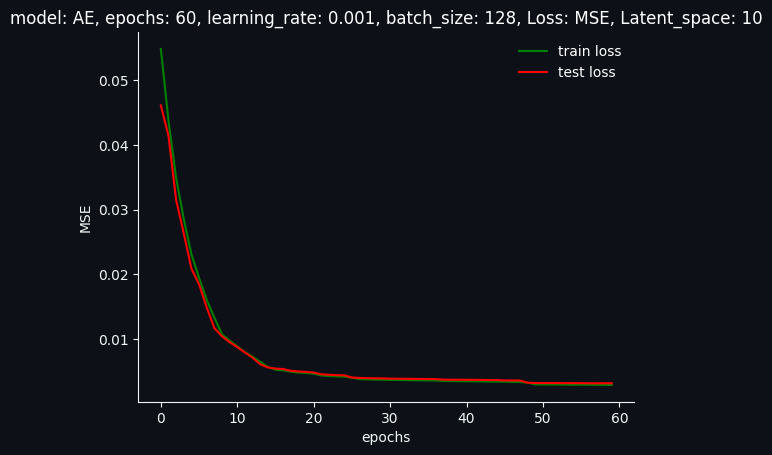

In [7]:
reduce_model.plot_loss()

In [8]:
main_reduced = reduce_model.transform(dataset)

In [ ]:
# TODO: сделать сохранение измененного датасета чтобы не пересчитывать каждый раз АЕ
# UPD: Веса сохранены в .pkl файле, можно просто загрузить их

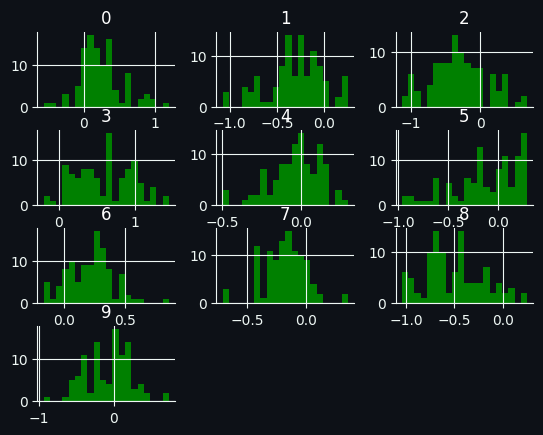

In [9]:
axes = pd.DataFrame(main_reduced).hist(bins=20)

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_2d(x1, y1, name):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax1.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[np.where(y1 == 0), 0], X_p[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax2.scatter(X_p[np.where(y1 == 1), 0], X_p[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

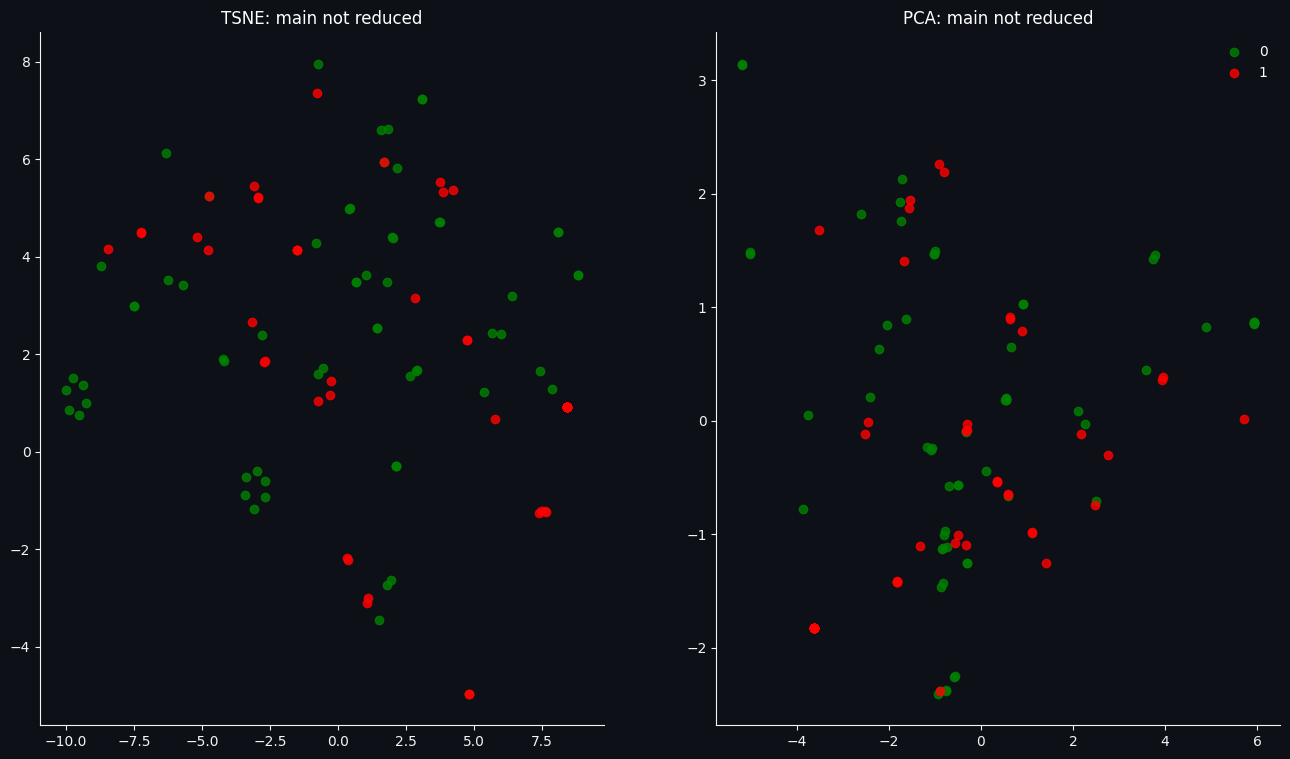

In [11]:
plot_2d(dataset, target, "main not reduced")

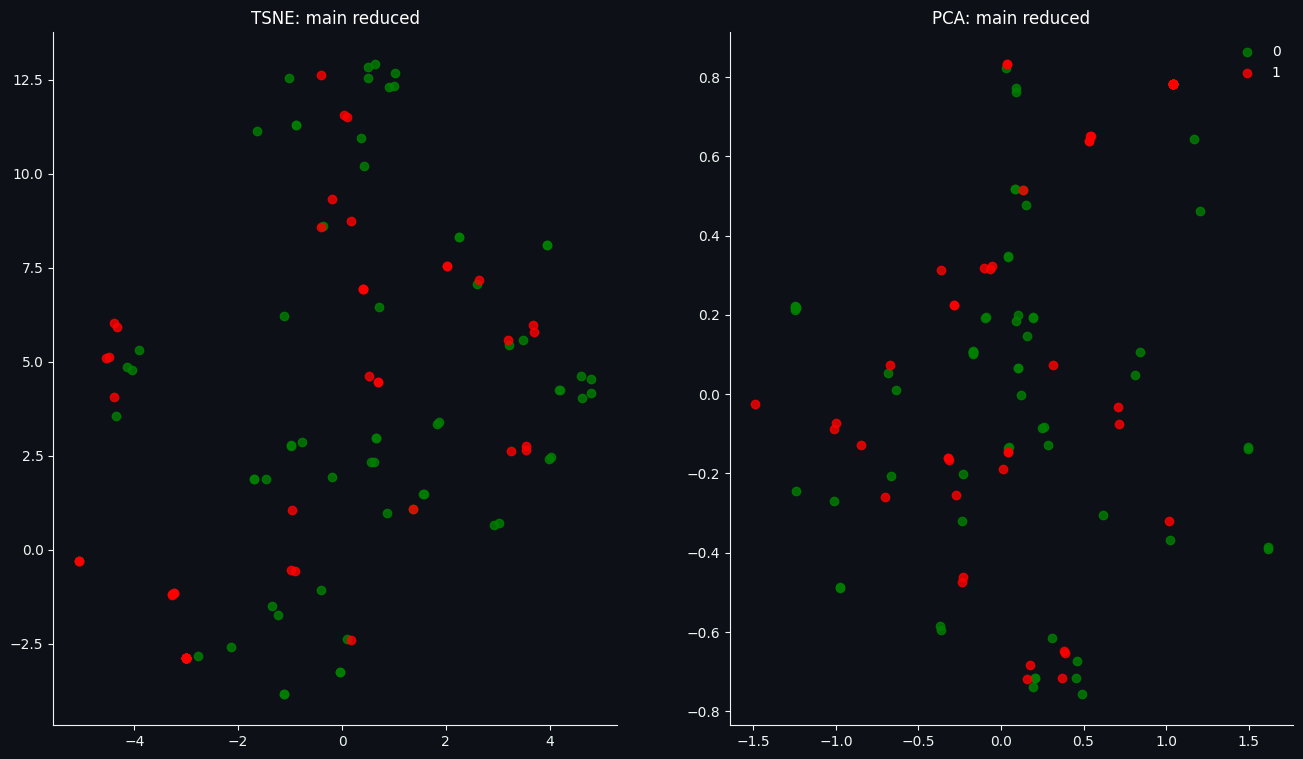

In [12]:
plot_2d(main_reduced, target, "main reduced")

# Classification

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0,
    #stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

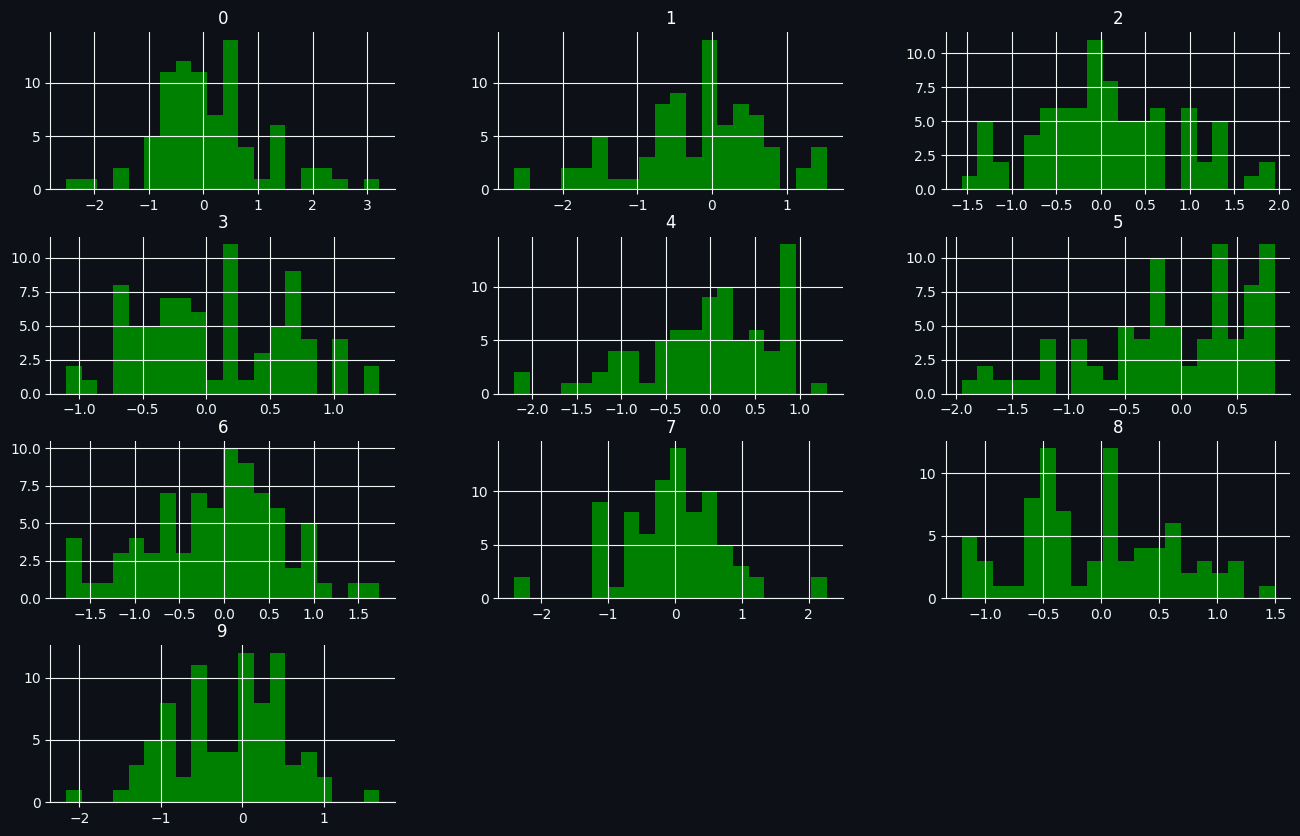

In [15]:
axes = pd.DataFrame(X_train).hist(bins=20, figsize=(16, 10))

In [16]:
c_model = ClassifierModel()
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)

evaluate CatBoost
  0%|          | 19/9223372036854775807 [00:10<1423217045739615:17:20,  1.80trial/s, best loss: -0.725]             
evaluate LGM
  0%|          | 28/9223372036854775807 [00:10<916981527923250:54:56,  2.79trial/s, best loss: -0.315] 
evaluate XGB
  0%|          | 14/9223372036854775807 [00:10<1830303514645387:39:44,  1.40trial/s, best loss: -0.613095238095238]
evaluate RF
  0%|          | 39/9223372036854775807 [00:10<660448066297791:34:24,  3.88trial/s, best loss: -0.6954545454545455]
evaluate AdaBoost
  0%|          | 40/9223372036854775807 [00:10<651783880604851:20:32,  3.93trial/s, best loss: -0.9337044534412957]


In [17]:
res

{'CatBoost': {'depth': 9,
  'l2_leaf_reg': 0.41989274807516475,
  'learning_rate': 0.007485348673826068,
  'n_estimators': 26,
  'score': 0.9391124871001032,
  'balance': {'test': {'0.0': 10, '1.0': 7}, 'train': {'0.0': 39, '1.0': 25}}},
 'LGM': {'learning_rate': 0.0023599445789194004,
  'max_depth': 7,
  'n_estimators': 50,
  'reg_lambda': 0.42128452374353487,
  'subsample': 0.322404311487539,
  'score': 0.315,
  'balance': {'test': {'0.0': 9, '1.0': 7}, 'train': {'0.0': 40, '1.0': 25}}},
 'XGB': {'learning_rate': 0.0026646120694637484,
  'max_depth': 8,
  'n_estimators': 57,
  'reg_lambda': 0.19027640036982407,
  'score': 0.6818181818181819,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 39, '1.0': 26}}},
 'RF': {'max_depth': 10,
  'n_estimators': 71,
  'score': 0.8747899159663866,
  'balance': {'test': {'0.0': 10, '1.0': 7}, 'train': {'0.0': 39, '1.0': 25}}},
 'AdaBoost': {'learning_rate': 0.004257413902418361,
  'max_depth': 9,
  'n_estimators': 44,
  'score': 0.9337

In [18]:
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
c_model.fit(X_train, y_train)

In [19]:
for name in c_model.models:
    pred = c_model.models[name].predict(X_test)
    print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
    print(metrics.classification_report(y_test, pred))

report for CatBoost: 0.62
              precision    recall  f1-score   support

         0.0       0.92      0.69      0.79        16
         1.0       0.44      0.80      0.57         5

    accuracy                           0.71        21
   macro avg       0.68      0.74      0.68        21
weighted avg       0.80      0.71      0.73        21

report for LGM: 0.21
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86        16
         1.0       0.00      0.00      0.00         5

    accuracy                           0.76        21
   macro avg       0.38      0.50      0.43        21
weighted avg       0.58      0.76      0.66        21

report for XGB: 0.67
              precision    recall  f1-score   support

         0.0       0.92      0.75      0.83        16
         1.0       0.50      0.80      0.62         5

    accuracy                           0.76        21
   macro avg       0.71      0.78      0.72        21
weight

c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [20]:
def roc_auc_plot(clf_model: ClassifierModel, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    for clf in clf_model.models:
        pred_proba = clf_model.models[clf].predict_proba(x_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 label=f"ROC curve {clf} (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="orange", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

def roc_auc_plot_one(clf: object, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    pred_proba = clf.predict_proba(x_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f"ROC curve: (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

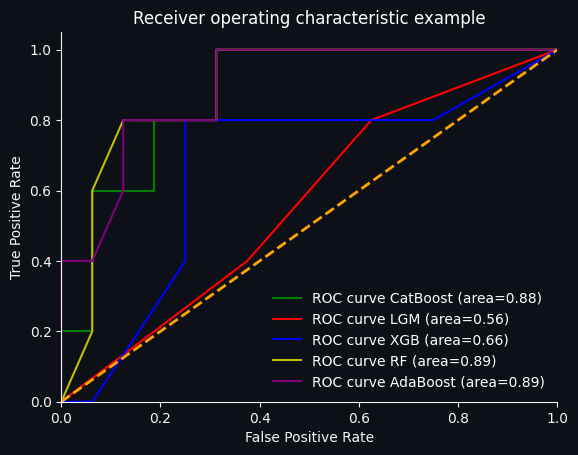

In [21]:
roc_auc_plot(c_model, X_test, y_test)

In [22]:
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

In [ ]:
# TODO: Посмотреть вероятности для каждого каждого классификатора

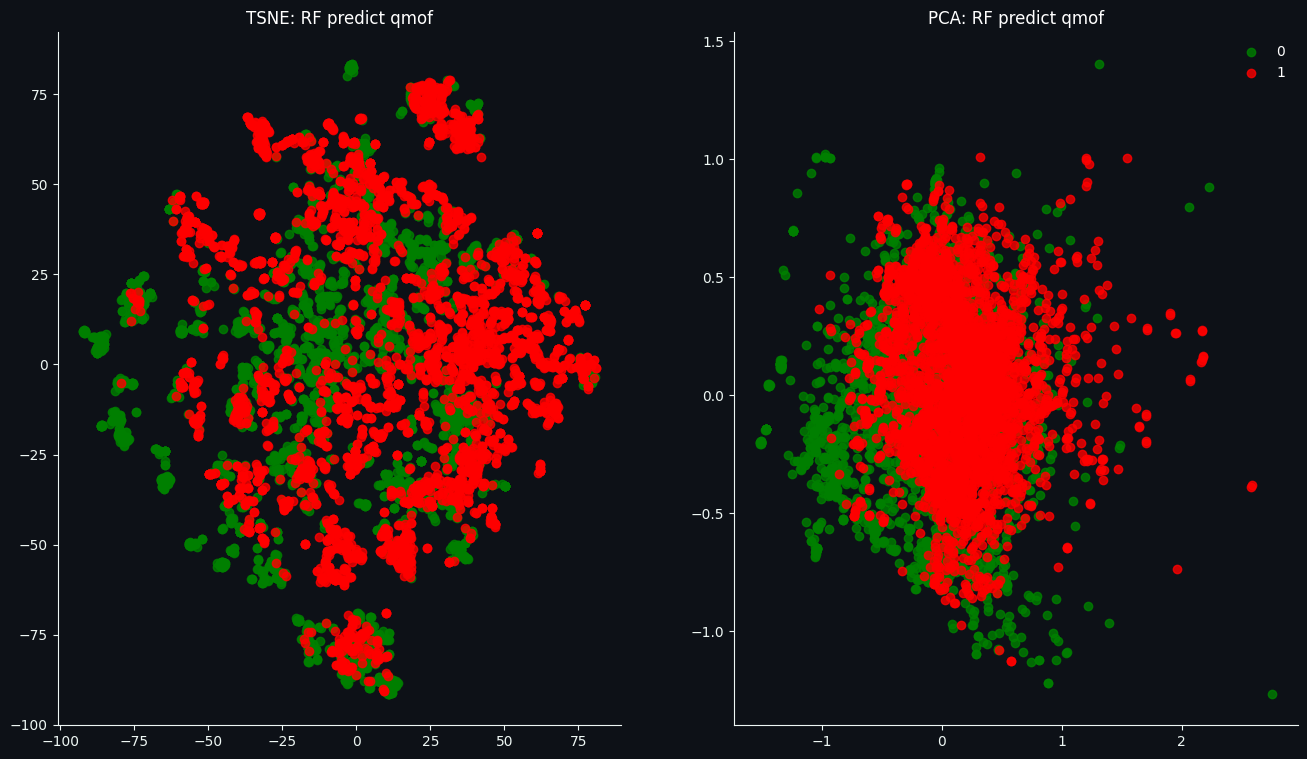

In [23]:
plot_2d(qmof_reduced, c_model.models["RF"].predict(qmof_reduced), "RF predict qmof")

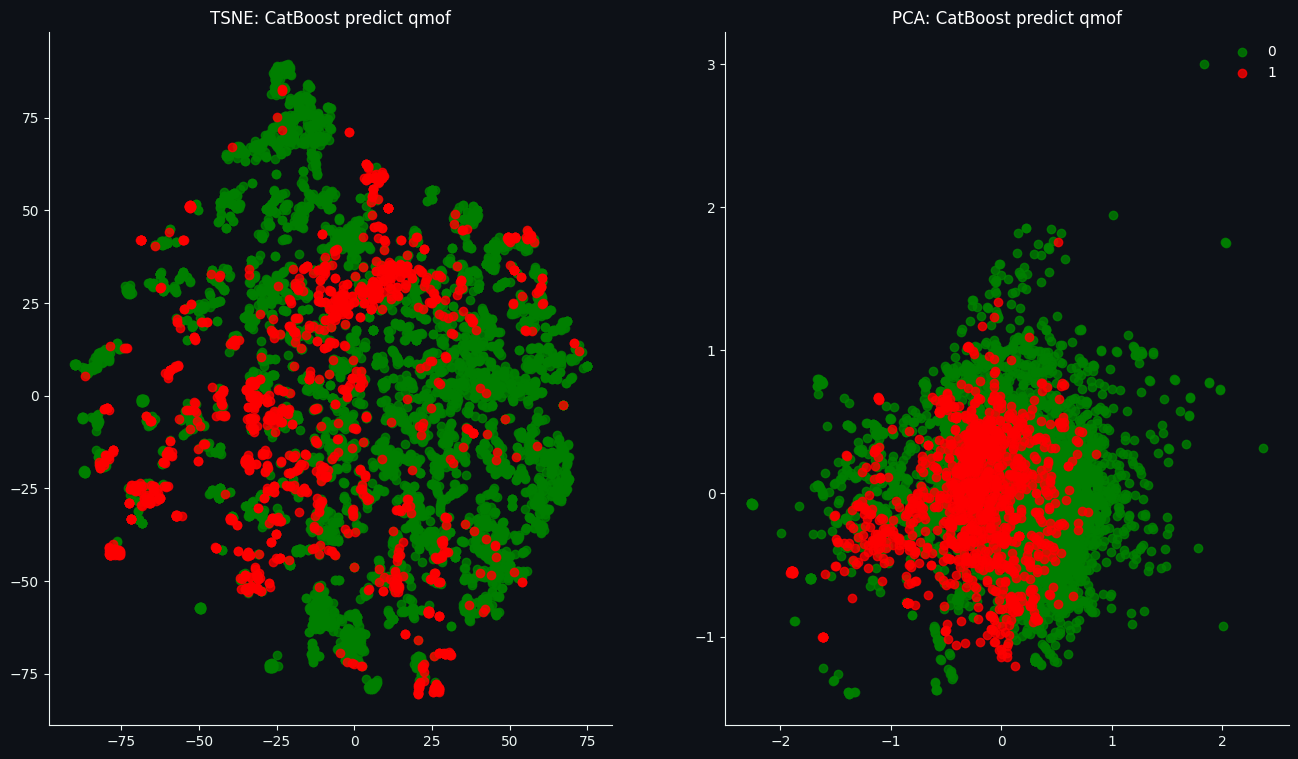

In [20]:
plot_2d(qmof_reduced, c_model.models["CatBoost"].predict(qmof_reduced), "CatBoost predict qmof")

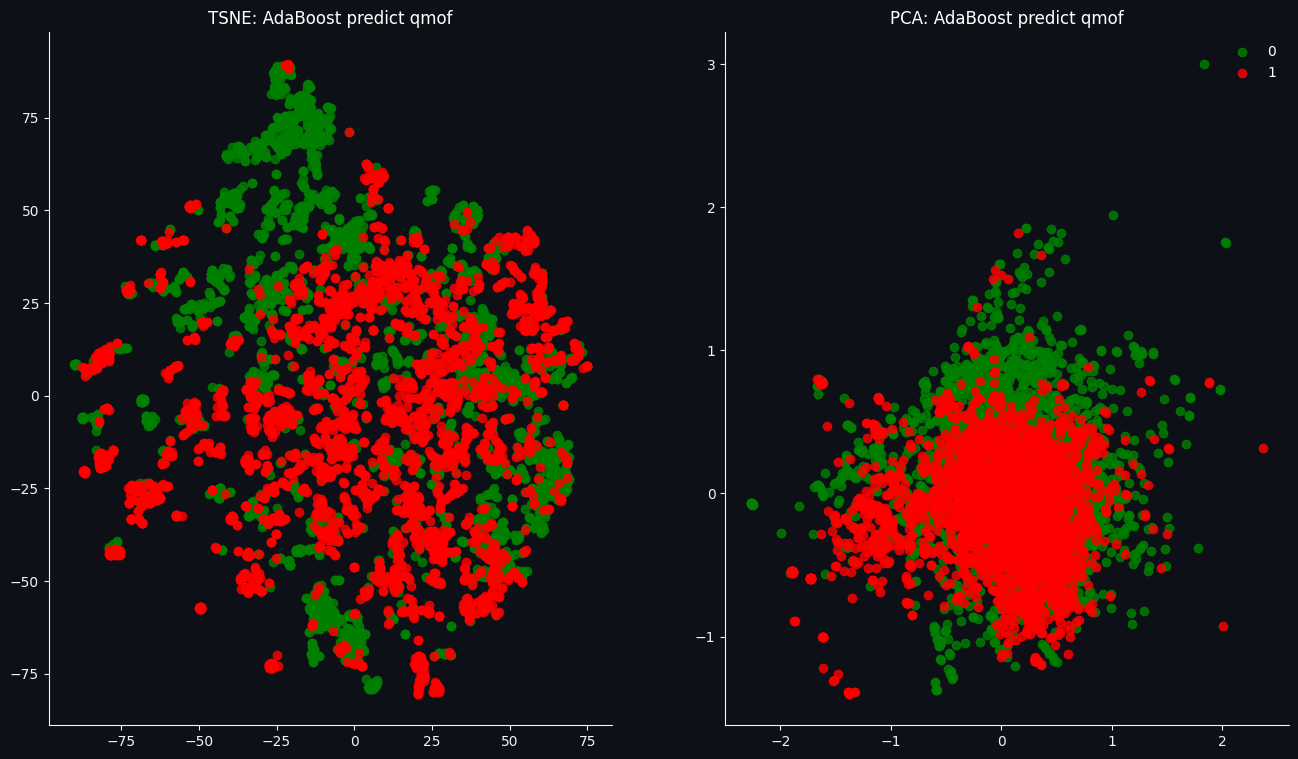

In [21]:
plot_2d(qmof_reduced, c_model.models["AdaBoost"].predict(qmof_reduced), "AdaBoost predict qmof")

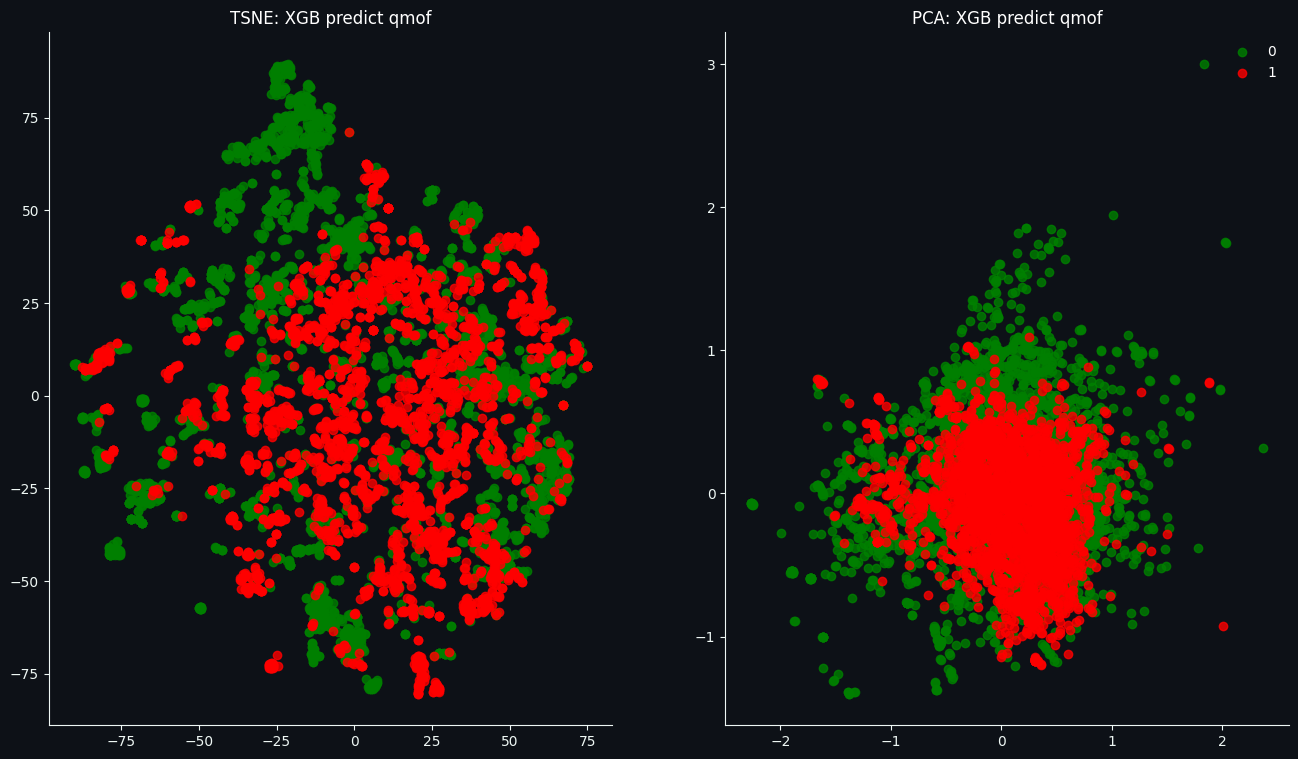

In [22]:
plot_2d(qmof_reduced, c_model.models["XGB"].predict(qmof_reduced), "XGB predict qmof")

In [23]:
import joblib

# в joblib нельзя сохранить модель на СUDA и загрузить на CPU
# поэтому сохраняем на CPU
# или 
# используем torch.save()
joblib.dump(reduce_model, "best/reduce_model.pkl")

joblib.dump(c_model, "best/c_model.pkl")

joblib.dump(res, "best/best_params.pkl")


['best/best_params.pkl']